In [1]:
from src.utils import *

# Wczytywanie i wstępne przetwarzanie sygnału EEG

In [2]:
name = "mati_ruch"
xml_file = f"data/{name}/{name}.obci.xml"
bin_file = f"data/{name}/{name}.obci.raw"
tag_file_path = f"data/{name}/{name}.obci.tag"

EEG = download_signal(bin_file, xml_file, tag_file_path)
EEG['data'], EEG['channels_names'] = apply_montage(EEG['data'], EEG['channels_names'], 'common_average')

2025-05-09 21:08:16,477 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [3]:
default_lowpass = {'N': 4, 'Wn': 45.0, 'ftype': 'butter'}
default_highpass = {'N': 4, 'Wn': 3.0, 'ftype': 'butter'}
default_notch = {'w0': 50.0, 'Q': 30.0}
EEG['data'] = filter_signal(EEG['data'], EEG['sampling'], lowpass_params=default_lowpass, highpass_params=default_highpass, notch_params=default_notch)

In [4]:
EEG['left'], EEG['right'] = cut_signal(EEG['data'], EEG['tags'], EEG['sampling'])
EEG['left_right'] = np.stack((EEG['left'], EEG['right']), axis=0)

# Analiza spektrogramów sygnałów EEG
Dla każdego kanału EEG został wykonany spektrogram, a następnie uśredniono widma po wszystkich realizacjach danego warunku. Ostateczne wyniki przedstawiono w formie map topograficznych przedstawiających rozkład mocy sygnału na powierzchni głowy.

In [5]:
from src.spectrogram import Spectrogram

spec = Spectrogram(fs=EEG['sampling'], baseline=2, nperseg=int(EEG['sampling']), noverlap=int(EEG['sampling']) - 1)

EEG['f'], EEG['t'], EEG['sxx_left'] = spec.compute_spectrogram(EEG['left'])
EEG['f'], EEG['t'], EEG['sxx_right'] = spec.compute_spectrogram(EEG['right'])

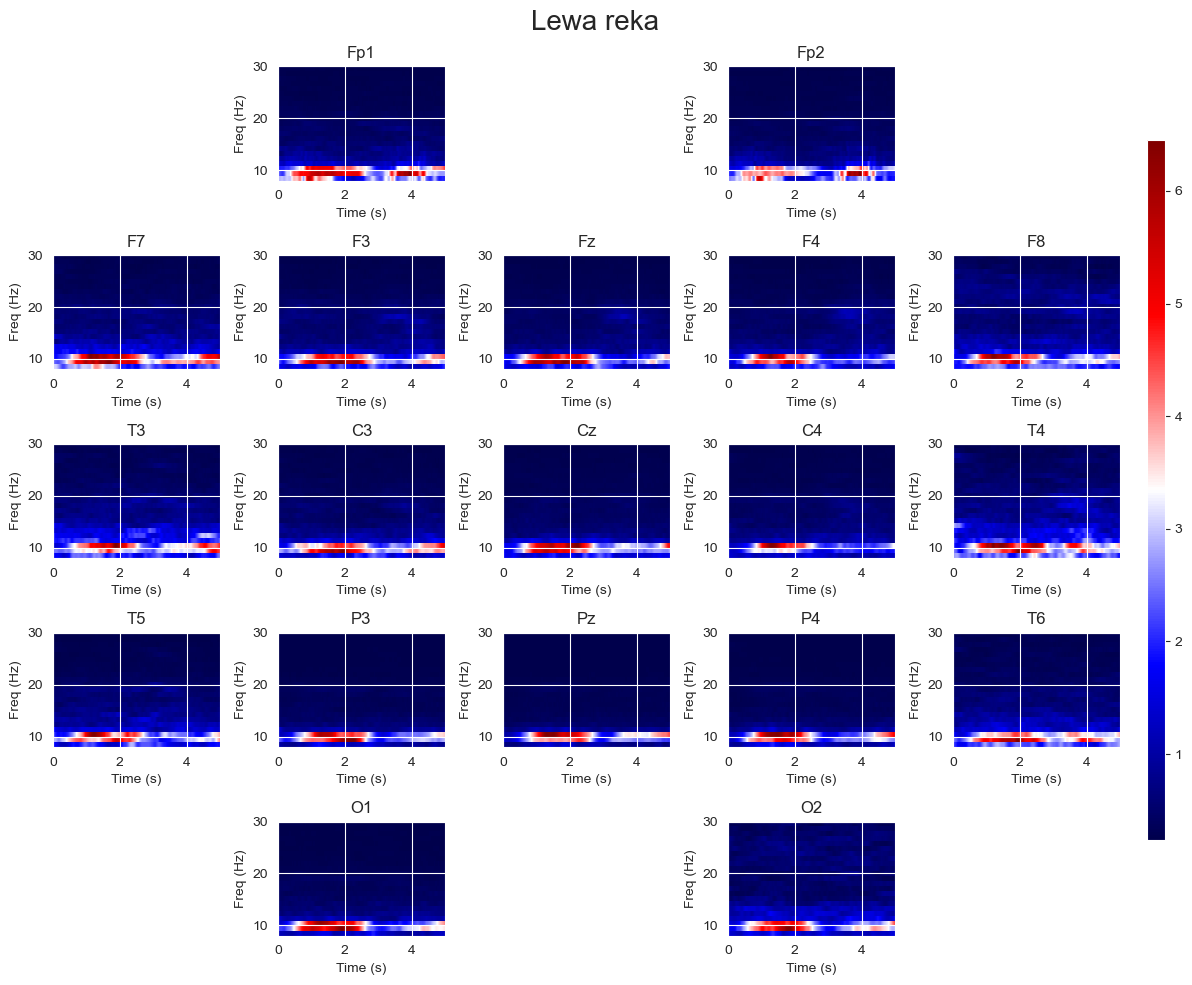

In [6]:
spec.plot_head(EEG['sxx_left'].copy().mean(axis=0), EEG['f'], EEG['t'], EEG['channels_names'], f_range=(8,30), t_range=(0,6), title="Lewa reka")

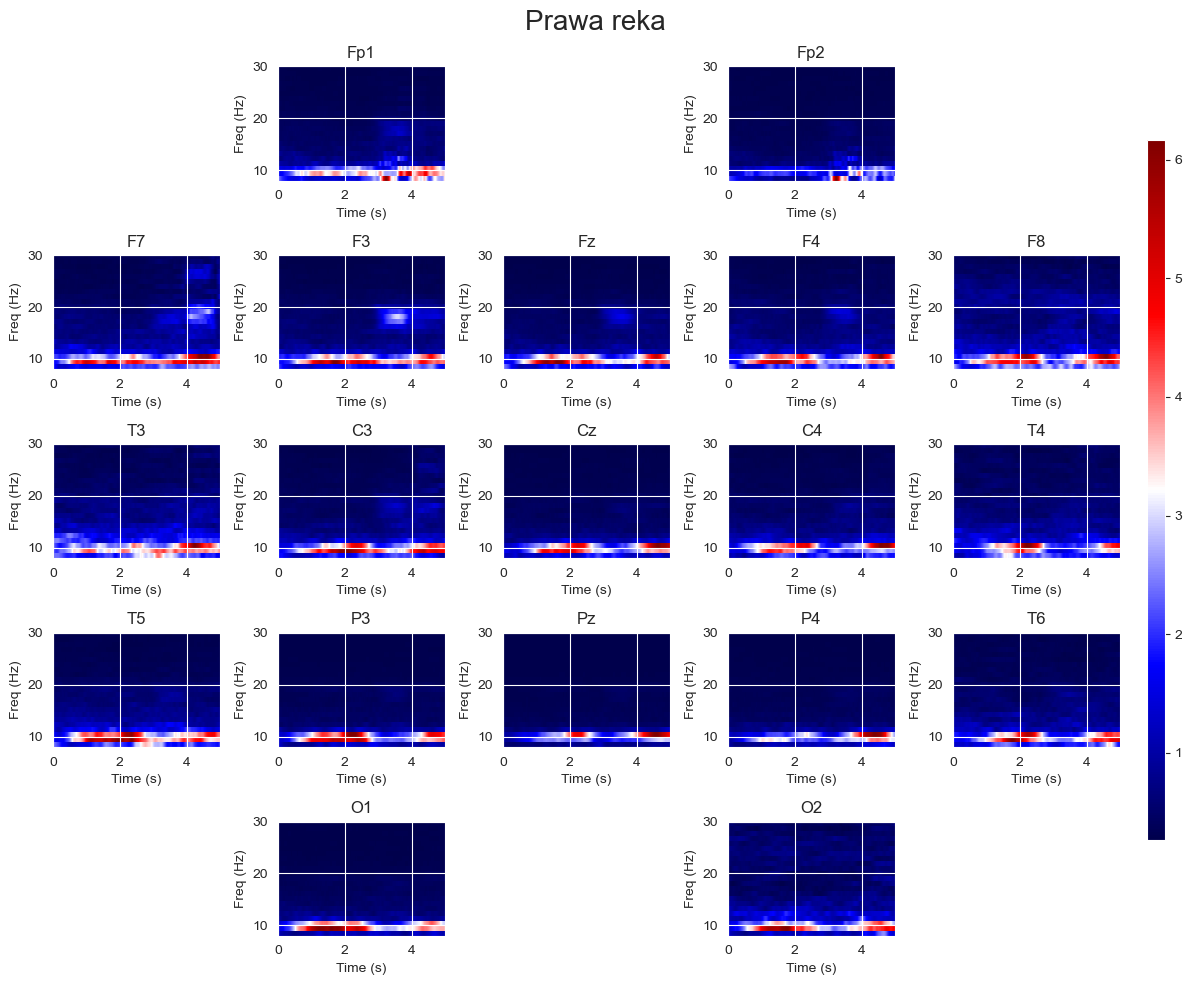

In [7]:
spec.plot_head(EEG['sxx_right'].copy().mean(axis=0), EEG['f'], EEG['t'], EEG['channels_names'], f_range=(8,30), t_range=(0,6), title="Prawa reka")

W spektrogramach można zauważyć spadek mocy w paśmie alfa (8–13 Hz) w momencie rozpoczęcia ruchu – czyli event-related desynchronization (ERD). Efekt ten jest szczególnie widoczny nad korą motoryczną, w naszym przypadku było to najlepiej widoczne w kanałach Pz i P4 dla ruchów lewej ręki oraz P3 i Pz dla ruchów prawej ręki.

## Spektrogramy po normalizacji 1

Następnie dokonano normalizacji widm względem bazowej aktywności (baseline).

$$
S_{\text{norm}}(f, t) = \frac{S_{\text{mean}}(f, t) - \mu_{\text{baseline}}(f)}{\mu_{\text{baseline}}(f)}
$$

czyli odejmujemy średnią moc z baseline’u i dzielimy przez tę samą średnią, otrzymując względną zmianę mocy.

In [8]:
EEG['sxx_norm1_left'] = spec.normalize_mean(EEG['sxx_left'])
EEG['sxx_norm1_right'] = spec.normalize_mean(EEG['sxx_right'])

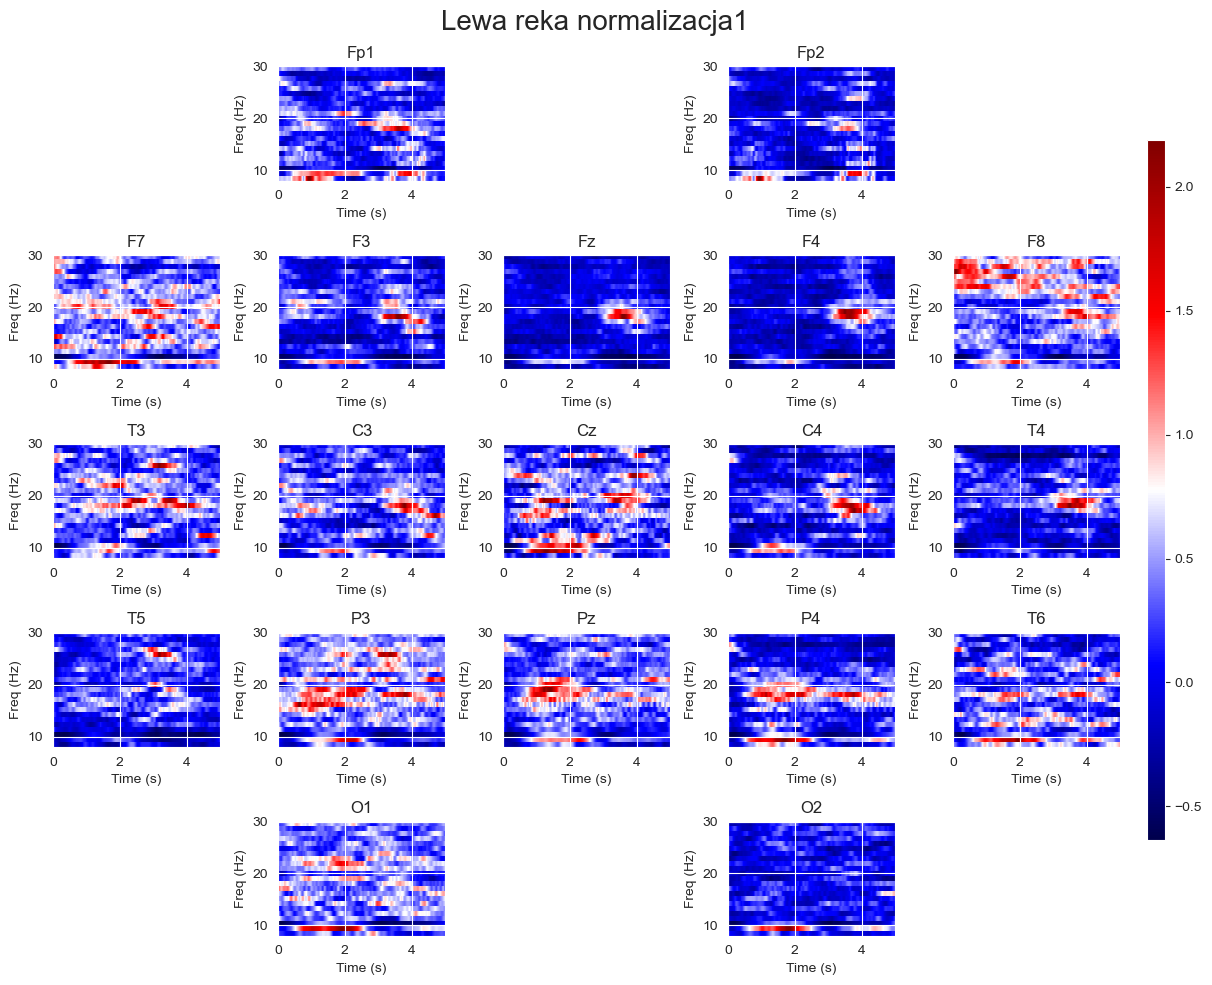

In [9]:
spec.plot_head(EEG['sxx_norm1_left'], EEG['f'], EEG['t'], EEG['channels_names'], f_range=(8,30), t_range=(0,6), title="Lewa reka normalizacja1")

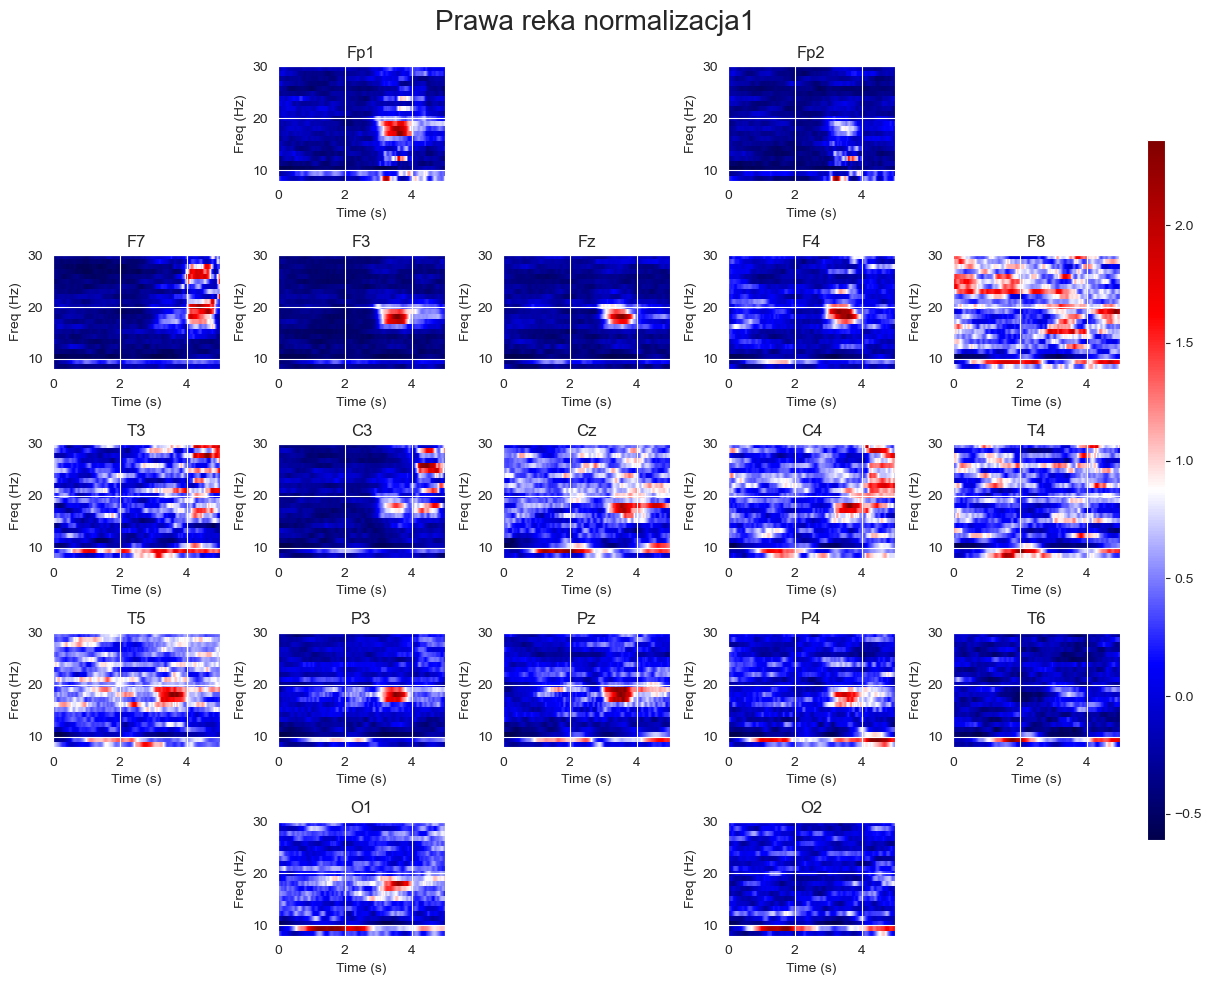

In [10]:
spec.plot_head(EEG['sxx_norm1_right'], EEG['f'], EEG['t'], EEG['channels_names'], f_range=(8,30), t_range=(0,6), title="Prawa reka normalizacja1")

Po normalizacji również można zauważyć spadek mocy w paśmie alfa (8–13 Hz) wokół momentu rozpoczęcia ruchu. Dodatkowo, około 1 sekundy po zakończeniu ruchu widoczny jest wzrost mocy w paśmie beta (13–30 Hz), czyli tzw. beta rebound, związany z mechanizmem event-related synchronization (ERS).

## Spektrogramy po normalizacji 2

Następnie zastosowano inną normalizację – standaryzację względem baseline’u.


$$
S_{\text{norm}}(f, t) = \frac{S_{\text{mean}}(f, t) - \mu_{\text{baseline}}(f)}{\sigma_{\text{baseline}}(f)}
$$

In [11]:
EEG['sxx_norm2_left'] = spec.normalize_zscore(EEG['sxx_left'])
EEG['sxx_norm2_right'] = spec.normalize_zscore(EEG['sxx_right'])

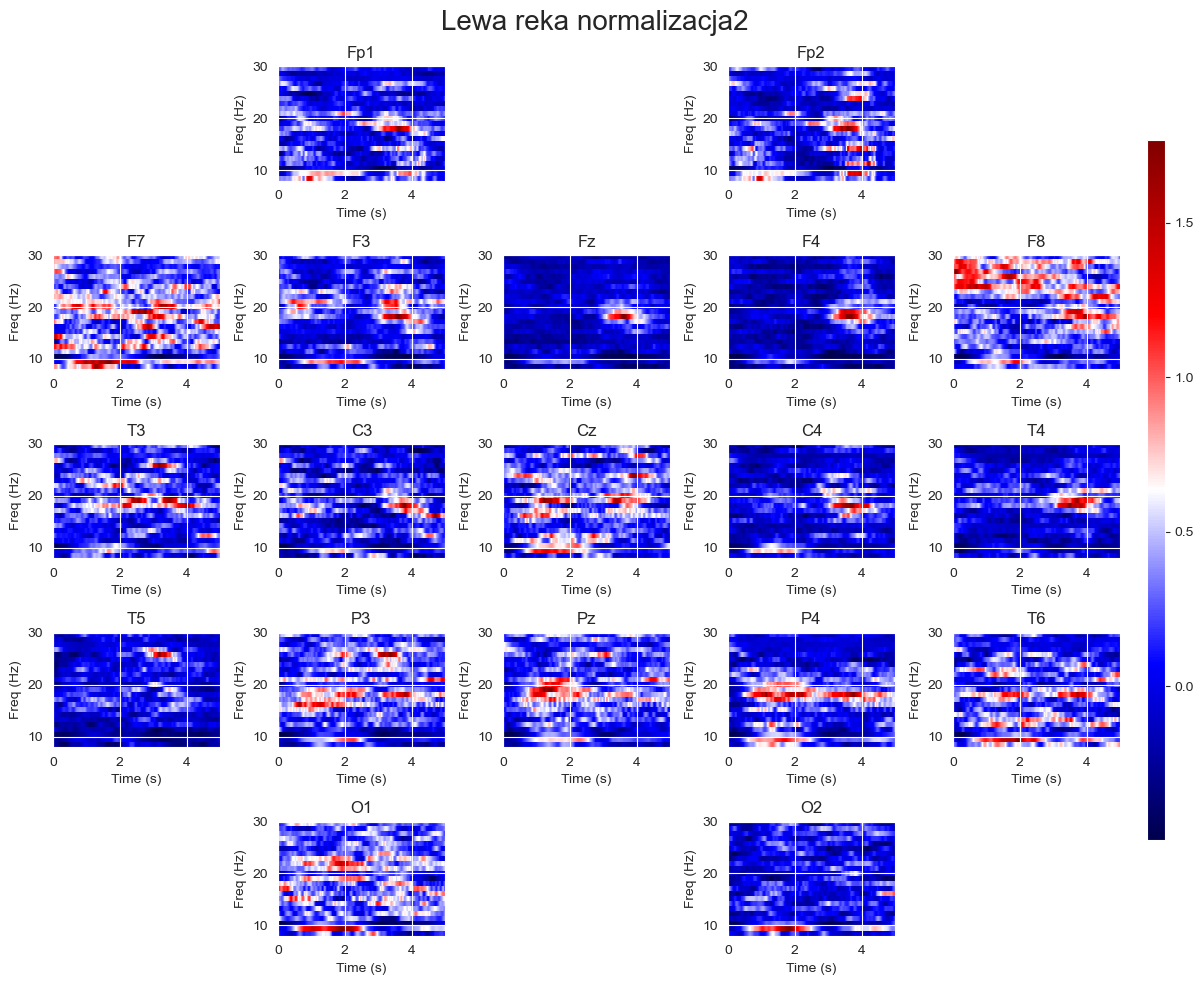

In [12]:
spec.plot_head(EEG['sxx_norm2_left'], EEG['f'], EEG['t'], EEG['channels_names'], f_range=(8,30), t_range=(0,6), title="Lewa reka normalizacja2")

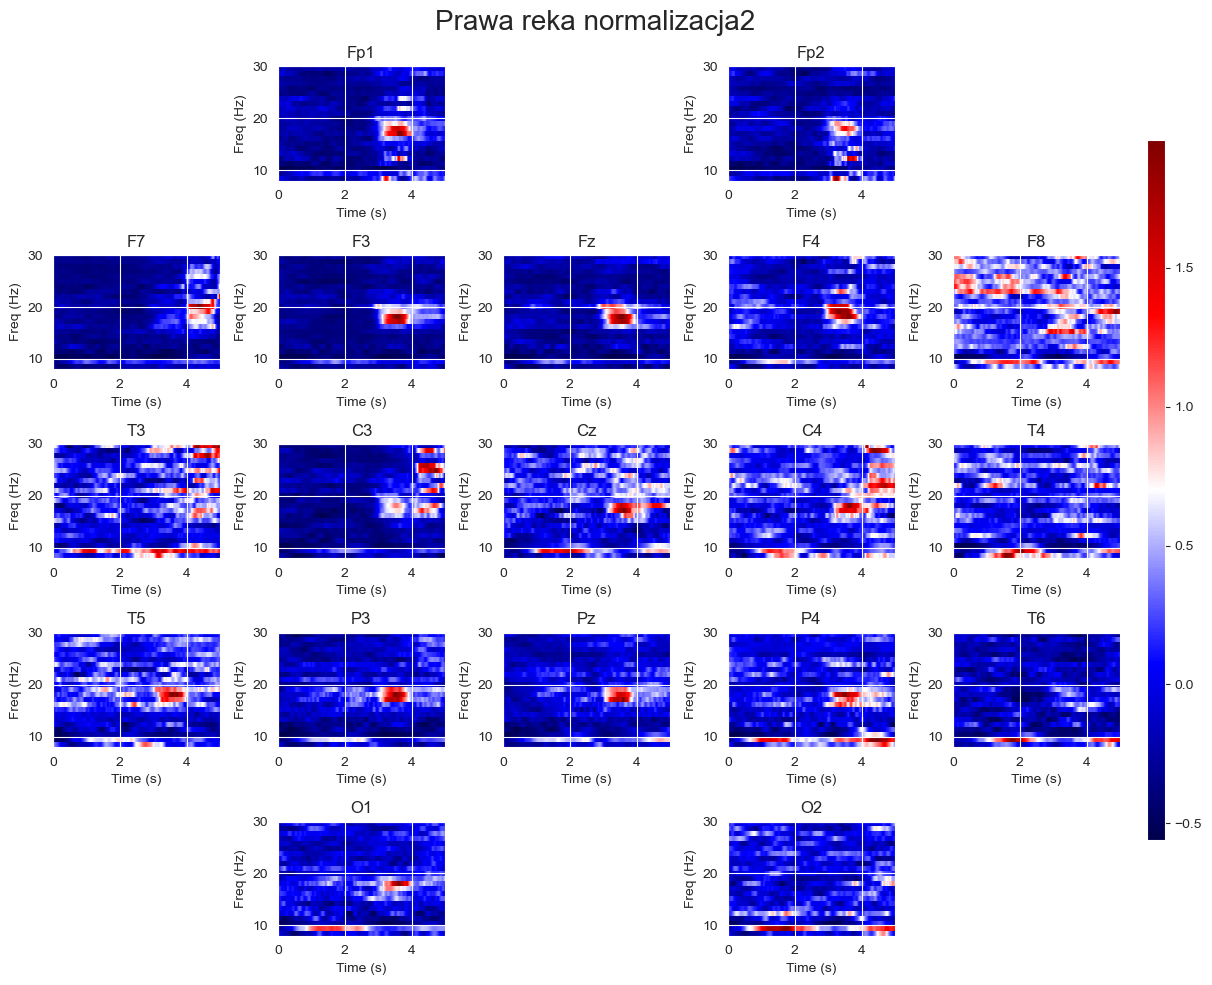

In [13]:
spec.plot_head(EEG['sxx_norm2_right'], EEG['f'], EEG['t'], EEG['channels_names'], f_range=(8,30), t_range=(0,6), title="Prawa reka normalizacja2")

# Common Spatial Patterns

Metoda Common Spatial Pattern (CSP) służy do znalezienia takich kierunków (kombinacji liniowych kanałów EEG), które maksymalizują różnicę w wariancji sygnału pomiędzy dwoma klasami (np. ruch lewą vs. prawą ręką). Zaimplementowany algorytm wygląda następująco:

**1. Obliczenie znormalizowanej macierzy kowariancji dla każdej próby:** Dla każdej próby obliczamy macierz kowariancji pomiędzy kanałami.

**2. Obliczenie średnich macierzy kowariancji**

**3. Rozwiązanie uogólnionego zagadnienia własnego:** Szukamy takich filtrów przestrzennych $\mathbf{w}$, które spełniają:

$$
\bar{\mathbf{C}}_L \mathbf{w} = \lambda \bar{\mathbf{C}}_R \mathbf{w}
$$


Kolumny macierzy $\mathbf{W}$ zawiera wektory własne, które mogą być użyte do projekcji sygnału EEG. Wektory odpowiadające największym i najmniejszym wartościom własnym $\lambda$ najlepiej rozróżniają klasy pod względem wariancji po projekcji.



In [14]:
from src.csp import CSP
csp = CSP()
EEG['left_trans'], EEG['right_trans'] = csp.fit_transform(EEG['left'], EEG['right'])

In [15]:
EEG['left_trans'].shape

(30, 21, 2048)

## Spektrogram komponentów CSP

In [16]:
EEG['f'], EEG['t'], EEG['sxx_left_trans'] = spec.compute_spectrogram(EEG['left_trans'])

EEG['f'], EEG['t'], EEG['sxx_right_trans'] = spec.compute_spectrogram(EEG['right_trans'])

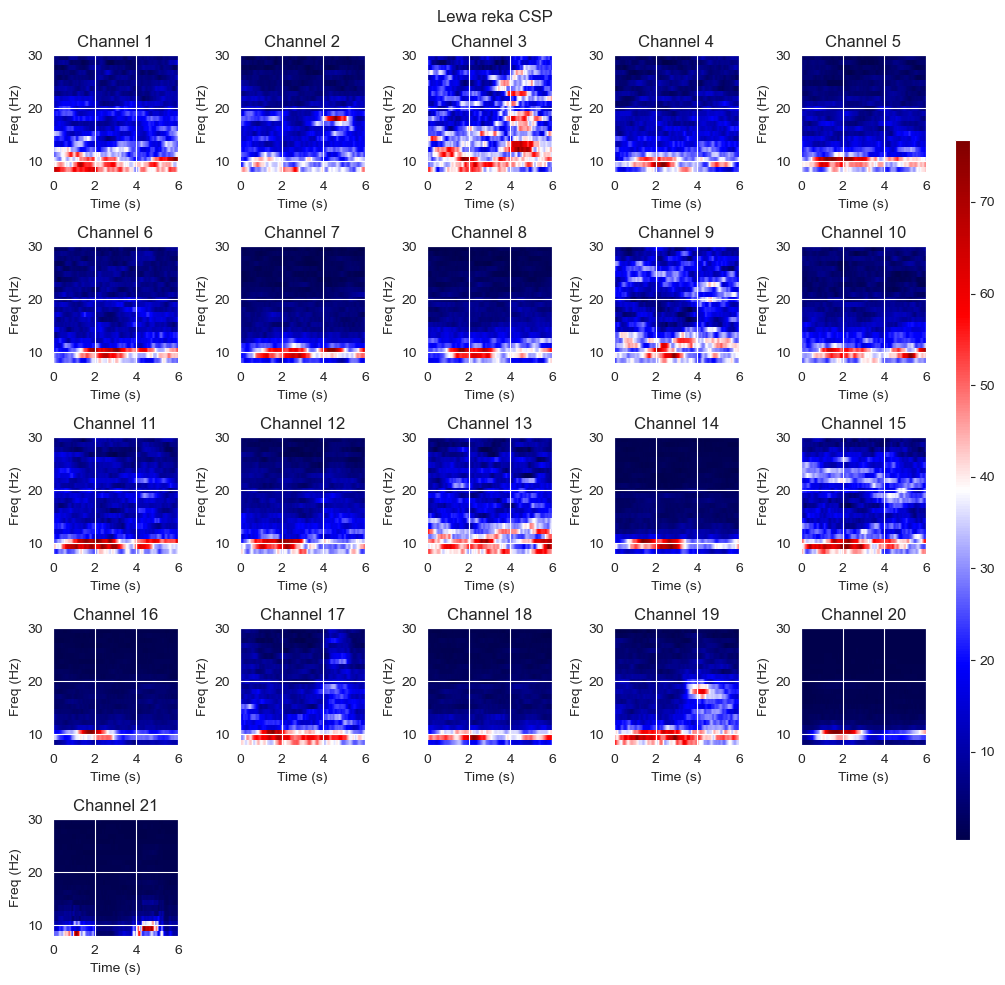

In [17]:
spec.plot_components(EEG['sxx_left_trans'].copy().mean(axis=0), EEG['f'], EEG['t'], f_range=(8,30), t_range=(0,6), title="Lewa reka CSP")

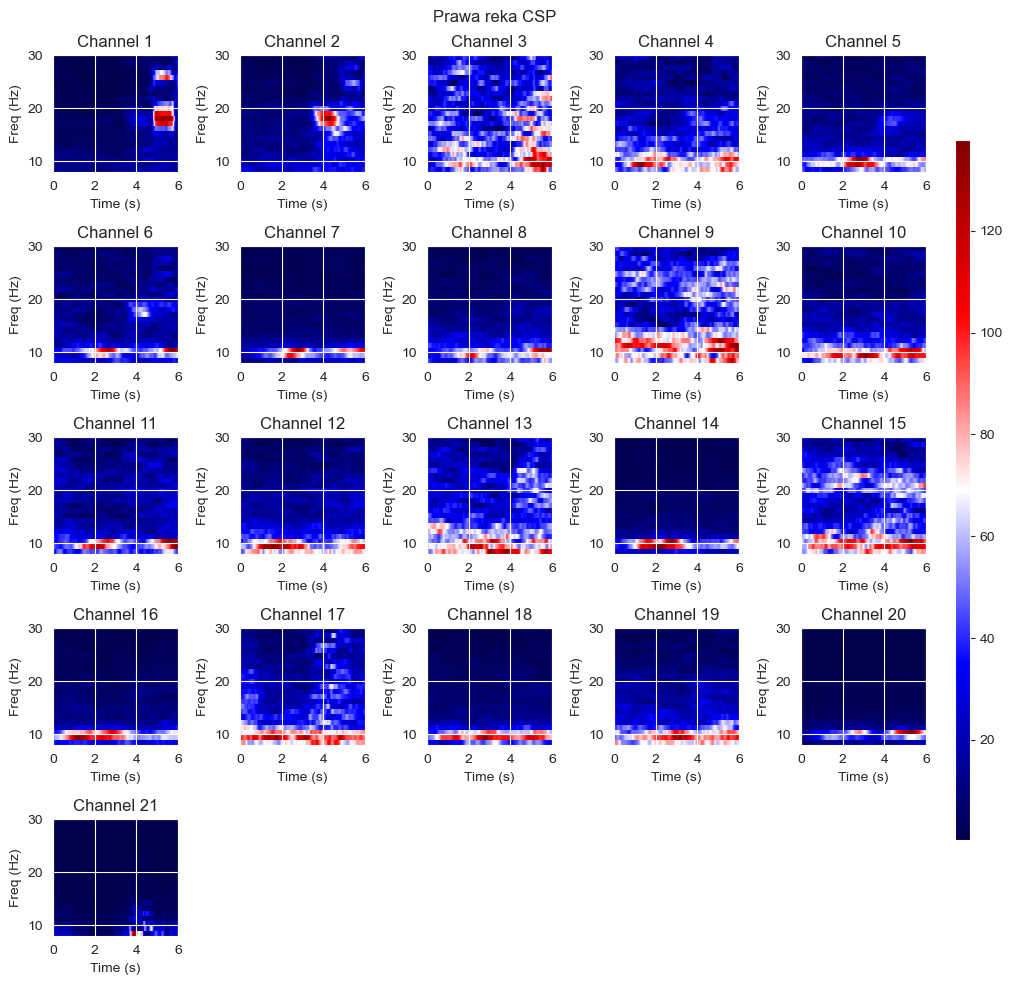

In [18]:
spec.plot_components(EEG['sxx_right_trans'].copy().mean(axis=0), EEG['f'], EEG['t'], f_range=(8,30), t_range=(0,6), title="Prawa reka CSP")

# Wybór komponentów

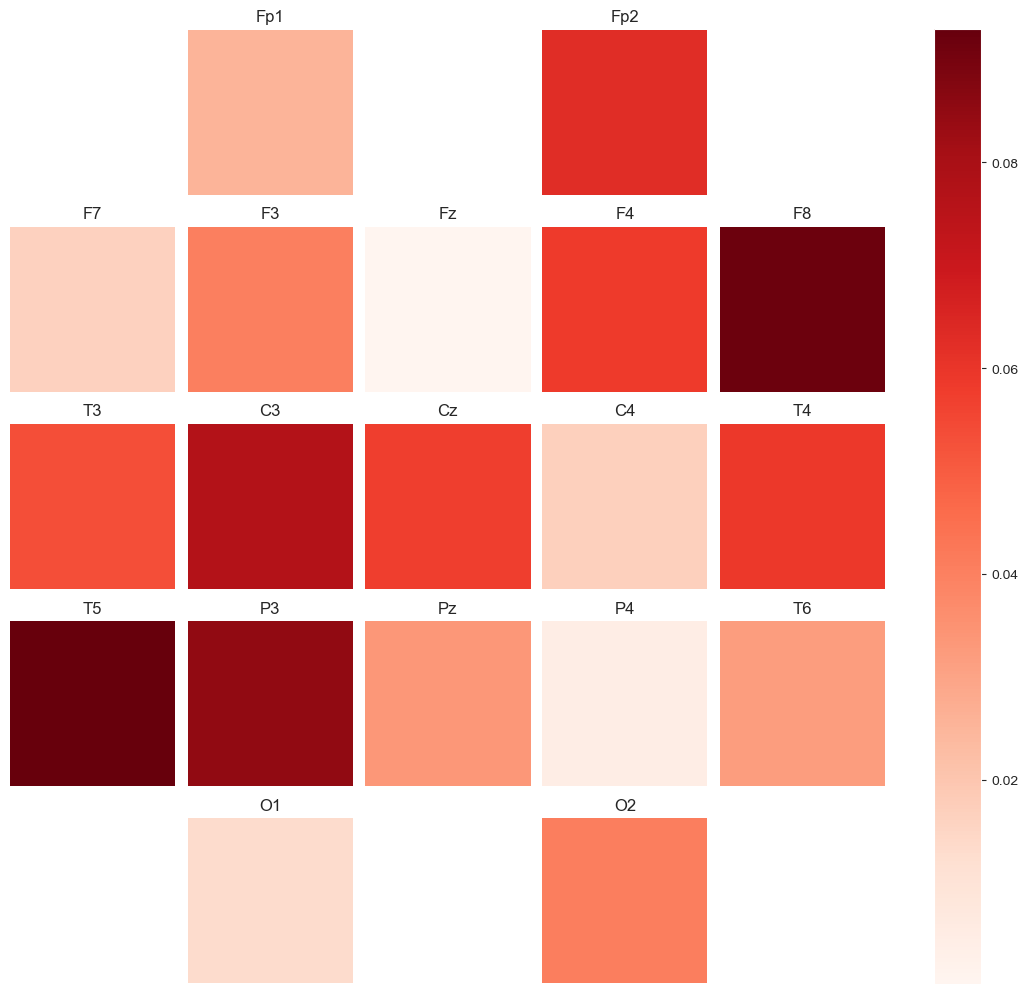

In [31]:
csp.plot_component(17, EEG['channels_names'])

# Stworzenie cech wejściowych do modelu

In [20]:
X = np.concatenate([EEG['left'], EEG['right']], axis=0)
y = np.hstack((np.zeros(EEG['left'].shape[0]), np.ones(EEG['right'].shape[0])))

# Trenowanie i ewaluacja modelu 

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

from src.eegClassifierPipeline import EEGClassifierPipeline

Classification accuracy: 0.4444

Confusion Matrix:
[[7 2]
 [8 1]]


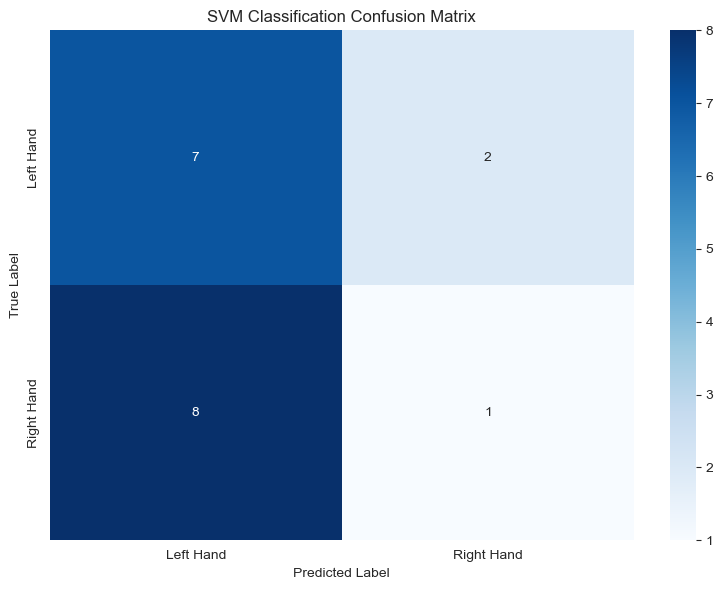

In [34]:
selected_components = [17, 19]
f_range = (8, 30)
t_range = (0, 5)
Fs = EEG['sampling']
NFFT = int(Fs)
classifier_type = 'svm'

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=231
)

# Wybór klasyfikatora
if classifier_type == 'lda':
    clf = LinearDiscriminantAnalysis()
elif classifier_type == 'svm':
    clf = SVC(kernel='linear', C=1, probability=True)

# Zbudowanie pipeline
pipeline = EEGClassifierPipeline(
    csp=CSP(),
    spectrogram=Spectrogram(fs=Fs, nperseg=NFFT, noverlap=NFFT-1),
    classifier=clf,
    csp_components=selected_components,
    f_range=f_range,
    t_range=t_range
)

# Trenowanie
pipeline.fit(X_train, y_train)

# Predykcja i ocena
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Classification accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(cm)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Left Hand', 'Right Hand'],
            yticklabels=['Left Hand', 'Right Hand'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{classifier_type.upper()} Classification Confusion Matrix')
plt.tight_layout()
plt.show()

In [35]:
from sklearn.model_selection import StratifiedKFold

cv_pipeline = EEGClassifierPipeline(
    csp=CSP(),
    spectrogram=Spectrogram(fs=Fs, nperseg=NFFT, noverlap=NFFT-1),
    classifier=clf,
    csp_components=selected_components,
    f_range=f_range,
    t_range=t_range
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(cv_pipeline, X, y, cv=cv)

print(f"5-fold cross-validation scores: {scores}")
print(f"Mean CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

5-fold cross-validation scores: [0.66666667 0.41666667 0.83333333 0.75       0.5       ]
Mean CV accuracy: 0.6333 ± 0.1546
